In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import Row
from pyspark.sql.functions import col, udf
#Mac: Path = "file:/Users/yungchuanlee/Documents/learn/kaggle"
#PC: Path = "file:///E:/R/kaggle"

In [2]:
global Path
if sc.master[0:5]=="local":
    Path = "file:/Users/yungchuanlee/Documents/learn/kaggle"
else:
    Path = "hdfs://master:9000/user/hduser"

# befor read data, remember to replace:
    * '\n",' with '",'
    * '\n[a-zA-Z0-9]' with ''(手動)
    * '"",""' with '',''
    * '"";""' with '';''


In [3]:
print("starting import training data...")
rawDataWithHd=sc.textFile(Path + "/QuoraQuestion/train.csv")
rawDataWithHd.take(2)
header = rawDataWithHd.first()
rawData=rawDataWithHd.filter(lambda line: line != header) #remove first line
rawDataRdd=rawData.map(lambda line: line.split("\",\""))
"""
#for checking training data
fieldCntRdd=rawDataRdd.map(lambda fields: Row(
    id=fields[0].replace("\"",""),
    fieldCnt=len(fields)
    ))
fieldCnt=spark.createDataFrame(fieldCntRdd)
fieldCnt.filter("fieldCnt != 6").show(30)
"""

starting import training data...


'\n#for checking training data\nfieldCntRdd=rawDataRdd.map(lambda fields: Row(\n    id=fields[0].replace(""",""),\n    fieldCnt=len(fields)\n    ))\nfieldCnt=spark.createDataFrame(fieldCntRdd)\nfieldCnt.filter("fieldCnt != 6").show(30)\n'

In [4]:
rowRdd=rawDataRdd.map(lambda fields: Row(
    id=fields[0].replace("\"",""),
    qid1=fields[1],
    qid2=fields[2],
    question1=fields[3],
    question2=fields[4],
    is_duplicate=fields[5].replace("\"","")
))
#trainRawData=spark.read.csv(Path + "/QuoraQuestion/train.csv", header=True, sep="\",\"")
trainRawData=spark.createDataFrame(rowRdd)
trainRawData.printSchema()
#trainRawData.show(5)
#print(trainRawData.columns)
print("Total train data count: " + str(trainRawData.count()))

root
 |-- id: string (nullable = true)
 |-- is_duplicate: string (nullable = true)
 |-- qid1: string (nullable = true)
 |-- qid2: string (nullable = true)
 |-- question1: string (nullable = true)
 |-- question2: string (nullable = true)

Total train data count: 404290


# befor read data, remember to replace:
    * '\n",' with '",'
    * '\n"' with '"'
    * ' \n[a-zA-Z0-9]' with ''(手動)
    * '"",""' with '',''
    * '"";""' with '';''

In [5]:
###### reading testing Data #######
print("starting import testing data...")
rawDataWithHd=sc.textFile(Path + "/QuoraQuestion/test.csv")
rawDataWithHd.take(2)
header = rawDataWithHd.first()
rawData=rawDataWithHd.filter(lambda line: line != header) #remove first line

starting import testing data...


In [6]:
###### reading testing Data #######
rawDataRdd=rawData.map(lambda line: line.split("\",\""))
"""
#For checking testing data
fieldCntRdd=rawDataRdd.map(lambda fields: Row(
    id=fields[0],
    fieldCnt=len(fields)
    ))
fieldCnt=spark.createDataFrame(fieldCntRdd)
fieldCnt.filter("fieldCnt != 2").count()
fieldCnt.filter("fieldCnt != 2").show(6)
"""

'\n#For checking testing data\nfieldCntRdd=rawDataRdd.map(lambda fields: Row(\n    id=fields[0],\n    fieldCnt=len(fields)\n    ))\nfieldCnt=spark.createDataFrame(fieldCntRdd)\nfieldCnt.filter("fieldCnt != 2").count()\nfieldCnt.filter("fieldCnt != 2").show(6)\n'

In [7]:
###### reading testing Data #######
rowRdd=rawDataRdd.map(lambda fields: 
    Row(
    test_id=fields[0].split(",\"")[0],
    question1=fields[0],
    question2=fields[1]
))

testRawData=spark.createDataFrame(rowRdd)
testRawData.printSchema()
#testRawData.show(5)

root
 |-- question1: string (nullable = true)
 |-- question2: string (nullable = true)
 |-- test_id: string (nullable = true)



In [8]:
###### reading testing Data #######
from pyspark.sql.functions import col
#udf
from pyspark.sql.functions import udf
def extractQuestion1(testId, question1):
    return question1.replace(testId+",\"", "")
extractQuestion1=udf(extractQuestion1)
testRawData=testRawData.select("test_id", extractQuestion1(col("test_id"),col("question1")).alias("question1"),"question2")
testRawData.show(5)
print("Total test data count: " + str(testRawData.count()))

+-------+--------------------+--------------------+
|test_id|           question1|           question2|
+-------+--------------------+--------------------+
|      0|How does the Surf...|Why did Microsoft...|
|      1|Should I have a h...|How much cost doe...|
|      2|What but is the b...|What you send mon...|
|      3|Which food not em...|  What foods fibre?"|
|      4|How ""aberystwyth...|How their can I s...|
+-------+--------------------+--------------------+
only showing top 5 rows

Total test data count: 2345796


In [9]:

from pyspark.sql.functions import udf
def toNumString(x):
    return (x if x.isnumeric() else "NaN")
toNumString=udf(toNumString)
"""
#udf for checking error data in trainRawData
idDt1=trainRawData.select([toNumString(col("id")).alias("id2")])#.filter("id2!='NaN'").select("id2")
idDt2=spark.range(0,404289)
idDt=idDt1.join(idDt2, idDt2.id==idDt1.id2, 'left_outer')
idDt.filter(idDt.id!=idDt.id2).show()#check if any error data
"""

'\n#udf for checking error data in trainRawData\nidDt1=trainRawData.select([toNumString(col("id")).alias("id2")])#.filter("id2!=\'NaN\'").select("id2")\nidDt2=spark.range(0,404289)\nidDt=idDt1.join(idDt2, idDt2.id==idDt1.id2, \'left_outer\')\nidDt.filter(idDt.id!=idDt.id2).show()#check if any error data\n'

In [10]:
numericCols=["qid1","qid2"]
labelCol="is_duplicate"
stringCols=[colName for colName in trainRawData.columns if colName not in numericCols+[labelCol]]
trainData=trainRawData.select(stringCols+[col(colName).cast("double").alias(colName) for colName in numericCols+[labelCol]]).filter(toNumString(col("id"))!="NaN")
trainData.printSchema()
print("Total train data count: " + str(trainData.count()))
# trainData.describe('is_duplicate').show()
# trainData.filter((trainData.is_duplicate>1) | (trainData.is_duplicate<0)).show()

root
 |-- id: string (nullable = true)
 |-- question1: string (nullable = true)
 |-- question2: string (nullable = true)
 |-- qid1: double (nullable = true)
 |-- qid2: double (nullable = true)
 |-- is_duplicate: double (nullable = true)

Total train data count: 404290


In [13]:
###### EDA for Training Data #######
qidsDf=(trainData.select(col("qid1").alias("qid"))).union(trainData.select(col("qid2").alias("qid")))
print('Total number of questions in the training data: {}'.format(qidsDf.select("qid").distinct().count()))
qidCntDf=qidsDf.groupBy("qid").count()
print('Number of questions that appear multiple times: {}'.format(qidCntDf.filter("count > 1").count()))
qidCntDf.orderBy("count", ascending=[0]).show(5)

Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780
+-------+-----+
|    qid|count|
+-------+-----+
| 2559.0|  157|
|30782.0|  120|
| 4044.0|  111|
| 2561.0|   88|
|14376.0|   79|
+-------+-----+
only showing top 5 rows



In [14]:
###### EDA for Training Data #######
qidCntPd=qidCntDf.toPandas().set_index("qid")

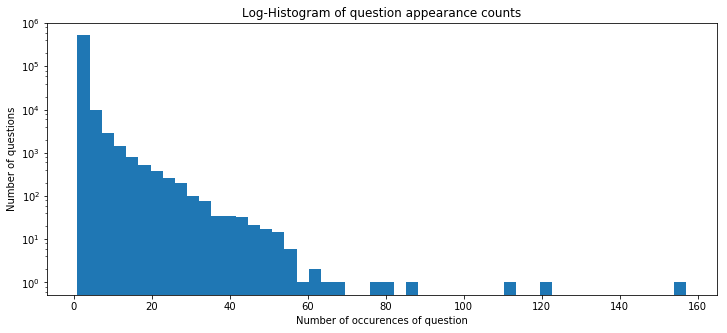

In [15]:
###### EDA for Training Data #######
plt.figure(figsize=(12, 5))
plt.hist(qidCntPd["count"], bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
plt.show()

In [11]:
###### reading Testing Data #######
testData=testRawData.select("test_id","question1","question2")
testData.printSchema()
print("Total test data count: " + str(testData.count()))

root
 |-- test_id: string (nullable = true)
 |-- question1: string (nullable = true)
 |-- question2: string (nullable = true)

Total test data count: 2345796


In [12]:
def getLength(x):
    return len(x)
getLength=udf(getLength)
def getLengthSplit(x):
    return len(x.split(' '))
getLengthSplit=udf(getLengthSplit)


In [17]:
###### EDA for Training & Testing Data #######
#analysis by length
trainQsDf=(trainData.select(col("question1").alias("question"))).union(trainData.select(col("question2").alias("question")))
trainQsLen1Pd=trainQsDf.select(getLength(col("question")).cast("integer").alias("qsLen")).toPandas()

testQsDf=(testData.select(col("question1").alias("question"))).union(testData.select(col("question2").alias("question")))
testQsLen1Pd=testQsDf.select(getLength(col("question")).cast("integer").alias("qsLen")).toPandas()



mean-train: 59.87, mean-test: 60.63
std-train: 31.99, std-test: 31.66
max-train: 1173.00, max-test: 1181.00


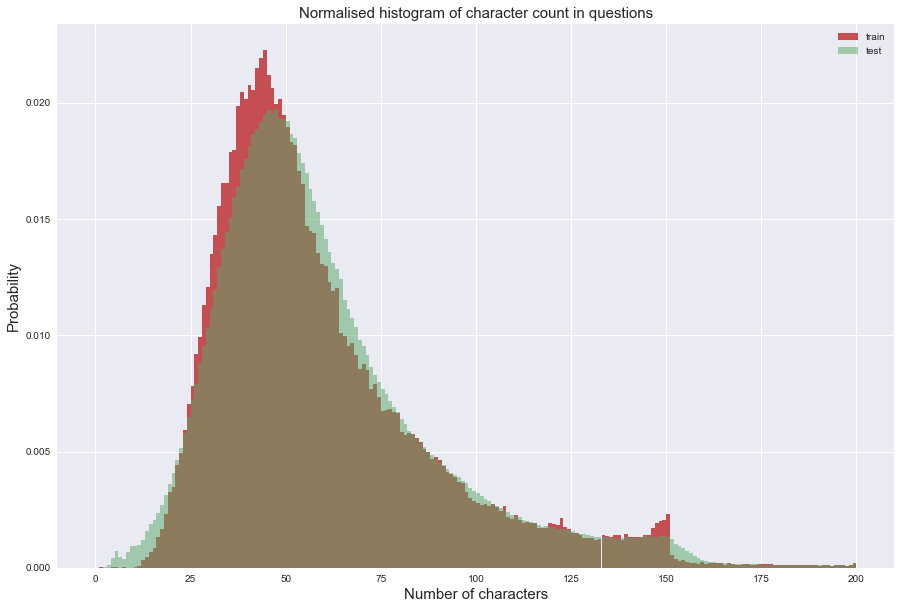

In [19]:
###### EDA for Training & Testing Data #######
#print hist of length analysis
import seaborn as sns
pal = sns.color_palette()
%matplotlib inline
plt.figure(figsize=(15, 10))
plt.hist(trainQsLen1Pd["qsLen"], bins=200, range=[0, 200], color=pal[2], normed=True, label='train')
plt.hist(testQsLen1Pd["qsLen"], bins=200, range=[0, 200], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print("mean-train: {:.2f}, mean-test: {:.2f}".format(trainQsLen1Pd["qsLen"].mean(), testQsLen1Pd["qsLen"].mean()))
print("std-train: {:.2f}, std-test: {:.2f}".format(trainQsLen1Pd["qsLen"].std(), testQsLen1Pd["qsLen"].std()))
print("max-train: {:.2f}, max-test: {:.2f}".format(trainQsLen1Pd["qsLen"].max(), testQsLen1Pd["qsLen"].max()))

In [20]:
###### EDA for Training & Testing Data #######
trainQsLen2Pd=trainQsDf.select(getLengthSplit(col("question")).cast("integer").alias("qsLen")).toPandas()
testQsLen2Pd=testQsDf.select(getLengthSplit(col("question")).cast("integer").alias("qsLen")).toPandas()

mean-train: 11.06, mean-test: 11.02
std-train: 5.89, std-test: 5.84
max-train: 237.00, max-test: 238.00


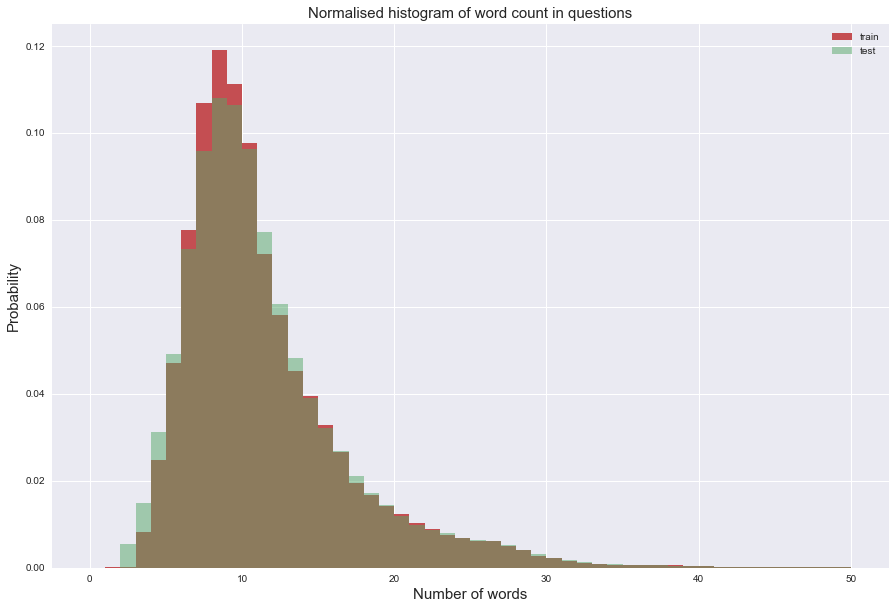

In [21]:
###### EDA for Training & Testing Data #######
plt.figure(figsize=(15, 10))
plt.hist(trainQsLen2Pd["qsLen"], bins=50, range=[0, 50], color=pal[2], normed=True, label='train')
plt.hist(testQsLen2Pd["qsLen"], bins=50, range=[0, 50], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print("mean-train: {:.2f}, mean-test: {:.2f}".format(trainQsLen2Pd["qsLen"].mean(), testQsLen2Pd["qsLen"].mean()))
print("std-train: {:.2f}, std-test: {:.2f}".format(trainQsLen2Pd["qsLen"].std(), testQsLen2Pd["qsLen"].std()))
print("max-train: {:.2f}, max-test: {:.2f}".format(trainQsLen2Pd["qsLen"].max(), testQsLen2Pd["qsLen"].max()))

In [50]:
from pyspark.sql.functions import lower, explode, split

In [22]:
########### EDA: Word count for trainData ##################
trainExplodeDf=trainData.select(explode(split(lower(col("question1")), ' ')).alias("words")). \
                union(trainData.select(explode(split(lower(col("question2")), ' ')).alias("words")))
trainExplodeDf.groupBy("words").count().orderBy("count", ascending=[0]).show(10)

+-----+------+
|words| count|
+-----+------+
|  the|376234|
| what|310963|
|   is|268849|
|  how|219019|
|    i|213184|
|    a|210233|
|   to|204067|
|   in|194724|
|   of|158912|
|   do|154720|
+-----+------+
only showing top 10 rows



In [14]:
import nltk
#nltk.download()
from nltk.corpus import stopwords
from pyspark.ml.feature import Tokenizer, RegexTokenizer, StopWordsRemover

In [24]:
########### EDA: Word count for trainData ##################
stops = set(stopwords.words("english"))
trainExplodeDf.filter(~ (col("words").isin (stops))).groupBy("words").count().orderBy("count", ascending=[0]).show(10)

+----------+-----+
|     words|count|
+----------+-----+
|      best|69692|
|       get|38736|
|      good|23640|
|    people|23608|
|     would|23503|
|      like|22387|
|       one|17891|
|      make|17724|
|       way|17134|
|    india?|16164|
|difference|13243|
|      know|12726|
|    what's|12334|
|       new|12290|
|     learn|12216|
|      much|11460|
|      many|11373|
|       use|11321|
|     think|11105|
|     india|10887|
|     money|10719|
|      find|10488|
|    indian|10344|
|    become| 9896|
|   without| 9883|
|      ever| 9667|
|   someone| 9548|
|      want| 9094|
|     start| 8987|
|      time| 8975|
|     quora| 8897|
|     first| 8677|
|    quora?| 8478|
|      why?| 7943|
|     trump| 7880|
|     could| 7807|
|     life?| 7795|
|      feel| 7776|
|     don't| 7773|
|      take| 7481|
|    better| 7465|
|       job| 6922|
|    really| 6836|
|      ways| 6829|
|    things| 6795|
|      life| 6786|
|       it?| 6778|
|    donald| 6694|
|  possible| 6536|
|      work|

In [25]:
########### EDA: Word count for trainData ##################
# word count by using ml lib
trainSentanceDf=trainData.select(col("question1").alias("question")).union(trainData.select(col("question2").alias("question")))
# tokenizer = Tokenizer(inputCol="question", outputCol="questionWords")
tokenizer = RegexTokenizer(inputCol="question", outputCol="questionWords", pattern="\\W")
trainWordsDf=tokenizer.transform(trainSentanceDf)
# trainWordsDf.show(5)
remover = StopWordsRemover(inputCol="questionWords", outputCol="filteredWords")
trainWordsDf=remover.transform(trainWordsDf)
# trainWordsDf.show(5)
trainExplodeDf=trainWordsDf.select(explode(col("filteredWords")).alias("words"))
trainExplodeDf.groupBy("words").count().orderBy("count", ascending=[0]).show(10)

+-----------+-----+
|      words|count|
+-----------+-----+
|       best|70602|
|        get|39545|
|      india|29564|
|     people|26414|
|       like|25648|
|       good|24871|
|      would|23648|
|        one|20052|
|      quora|18233|
|       make|18207|
|        way|18118|
|       life|16498|
|       time|15089|
|      money|14588|
|       know|13778|
| difference|13388|
|      learn|13088|
|        new|12444|
|        use|12378|
|       much|12370|
|    someone|12027|
|      think|11505|
|       many|11461|
|       work|11261|
|     indian|10798|
|      trump|10774|
|       ever|10577|
|       find|10572|
|    without|10024|
|      world| 9941|
|     become| 9915|
|      start| 9886|
|     online| 9767|
|     better| 9698|
|      first| 9698|
|       year| 9458|
|       want| 9370|
|       mean| 8755|
|          2| 8732|
|        job| 8698|
|    english| 8553|
|         us| 8457|
|          1| 8012|
|       feel| 8010|
|       love| 7969|
|      could| 7916|
|       2016| 7915|


In [26]:
"""
#Testing tokenizer & remover by pipeline
from pyspark.ml import Pipeline
testPipe=Pipeline(stages=[tokenizer, remover])
testModel=testPipe.fit(trainSentanceDf)
testModel.transform(trainSentanceDf).show(10)
"""

+--------------------+--------------------+--------------------+
|            question|       questionWords|       filteredWords|
+--------------------+--------------------+--------------------+
|What is the step ...|[what, is, the, s...|[step, step, guid...|
|What is the story...|[what, is, the, s...|[story, kohinoor,...|
|How can I increas...|[how, can, i, inc...|[increase, speed,...|
|Why am I mentally...|[why, am, i, ment...|[mentally, lonely...|
|Which one dissolv...|[which, one, diss...|[one, dissolve, w...|
|Astrology: I am a...|[astrology, i, am...|[astrology, capri...|
| Should I buy tiago?|[should, i, buy, ...|        [buy, tiago]|
|How can I be a go...|[how, can, i, be,...|   [good, geologist]|
|When do you use シ...|[when, do, you, u...|      [use, instead]|
|Motorola (company...|[motorola, compan...|[motorola, compan...|
+--------------------+--------------------+--------------------+
only showing top 10 rows



In [27]:
#build pipeline to generate dataframe with id|question1|question2|qid1|qid2|is_duplicate|words1|words2
""" Using RegexTokenizer (not use becaue of removing non-english words like japannise)
tokenizer1 = RegexTokenizer(inputCol="question1", outputCol="questionWords1", pattern="\\W")
tokenizer2 = RegexTokenizer(inputCol="question2", outputCol="questionWords2", pattern="\\W")
remover1 = StopWordsRemover(inputCol="questionWords1", outputCol="words1")
remover2 = StopWordsRemover(inputCol="questionWords2", outputCol="words2")
tokenRemovePipe = Pipeline(stages=[tokenizer1, tokenizer2, remover1, remover2])
tokenRemovePipeModel = tokenRemovePipe.fit(trainData)
trainDataWithWords=tokenRemovePipeModel.transform(trainData)
trainDataWithWords.select(["questionWords1", "questionWords2", "words1", "words2", "is_duplicate"]).show(10)
"""

+--------------------+--------------------+--------------------+--------------------+------------+
|      questionWords1|      questionWords2|              words1|              words2|is_duplicate|
+--------------------+--------------------+--------------------+--------------------+------------+
|[what, is, the, s...|[what, is, the, s...|[step, step, guid...|[step, step, guid...|         0.0|
|[what, is, the, s...|[what, would, hap...|[story, kohinoor,...|[would, happen, i...|         0.0|
|[how, can, i, inc...|[how, can, intern...|[increase, speed,...|[internet, speed,...|         0.0|
|[why, am, i, ment...|[find, the, remai...|[mentally, lonely...|[find, remainder,...|         0.0|
|[which, one, diss...|[which, fish, wou...|[one, dissolve, w...|[fish, would, sur...|         0.0|
|[astrology, i, am...|[i, m, a, triple,...|[astrology, capri...|[triple, capricor...|         1.0|
|[should, i, buy, ...|[what, keeps, chi...|        [buy, tiago]|[keeps, childern,...|         0.0|
|[how, can

In [15]:
from pyspark.ml import Pipeline

In [16]:
# import re, string
# def replacePunct(question):
#     for c in string.punctuation:  
#         question = question.replace(c,"")
#     return question                                
# replacePunct=udf(replacePunct)
# trainData2=trainData.select(["id", "qid1", replacePunct(col("question1")).alias("question1"), "qid2", replacePunct(col("question2")).alias("question2"), "is_duplicate"])
#trainData2.show(5)
tokenizer1 = Tokenizer(inputCol="question1", outputCol="questionWords1")
tokenizer2 = Tokenizer(inputCol="question2", outputCol="questionWords2")
remover1 = StopWordsRemover(inputCol="questionWords1", outputCol="words1")
remover2 = StopWordsRemover(inputCol="questionWords2", outputCol="words2")
tokenRemovePipe = Pipeline(stages=[tokenizer1, tokenizer2, remover1, remover2])
tokenRemovePipeModel = tokenRemovePipe.fit(trainData)
trainDataWithWords=tokenRemovePipeModel.transform(trainData)
#trainDataWithWords.select(["questionWords1", "questionWords2", "words1", "words2", "is_duplicate"]).filter("id='8'").collect()

In [17]:
from __future__ import division
def getWeight(words1, words2):
    if len(words1) == 0 or len(words2) == 0:
        return 0
    shared_word_1 = [word for word in words1 if word in words2]
    shared_word_2 = [word for word in words2 if word in words1]
    R = (len(shared_word_1) + len(shared_word_2))/(len(words1) + len(words2))
    return R
getWeight=udf(getWeight)
trainWeightData=trainDataWithWords.select(["words1", "words2",getWeight(col("words1"),col("words2")).alias("weight"), "is_duplicate"])
#trainWeightData.show(10)

In [30]:
############### EDA for training data with shared word ####################
trainWeightPd0=trainWeightData.select(col("weight").cast("double")).filter("is_duplicate=0").toPandas()
trainWeightPd1=trainWeightData.select(col("weight").cast("double")).filter("is_duplicate=1").toPandas()


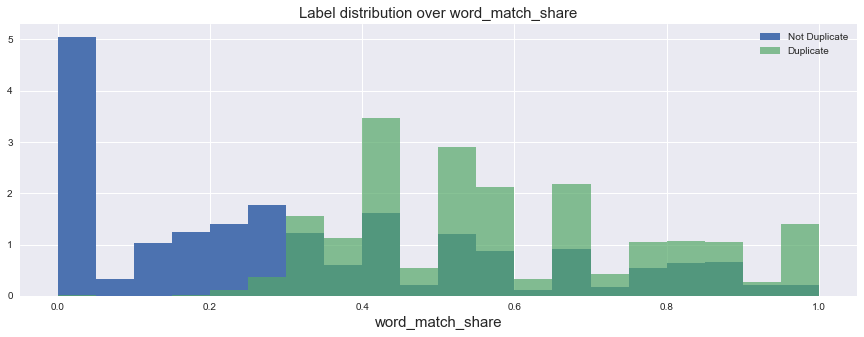

In [31]:
############### EDA for training data with shared word ####################
# trainWeightPd0["weight"]
plt.figure(figsize=(15, 5))
plt.hist(trainWeightPd0["weight"], bins=20, normed=True, label='Not Duplicate')
plt.hist(trainWeightPd1["weight"], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)
plt.show()

In [18]:
#################### prepare testing Data for Predict with share word weight ################
#predict with word match
testPipeModel = tokenRemovePipe.fit(testData)
testDataWithWords=testPipeModel.transform(testData)
testDataWithWords.printSchema()
#testDataWithWords.select(["questionWords1", "questionWords2", "words1", "words2"]).filter("test_id='8'").collect()

root
 |-- test_id: string (nullable = true)
 |-- question1: string (nullable = true)
 |-- question2: string (nullable = true)
 |-- questionWords1: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- questionWords2: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- words1: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- words2: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [19]:
#################### Predict with share word weight ################
testWeightData=testDataWithWords.select(["test_id", "words1", "words2",getWeight(col("words1"),col("words2")).alias("weight")])
testWeightData.show(10)

+-------+--------------------+--------------------+-------------------+
|test_id|              words1|              words2|             weight|
+-------+--------------------+--------------------+-------------------+
|      0|[surface, pro, 4,...|[microsoft, choos...|               0.25|
|      1|[hair, transplant...|[much, cost, hair...|                0.5|
|      2|[best, way, send,...|[send, money, chi...| 0.4444444444444444|
|      3|[food, emulsifiers?]|    [foods, fibre?"]|                0.0|
|      4|[""aberystwyth"",...|  [start, reading?"]|                0.4|
|      5|[two, wheeler, in...|[admire, consider...|0.18181818181818182|
|      6|[reduce, belly, f...|[reduce, lower, b...|                0.6|
|      7|[scrapping, 500, ...|[recent, move, de...| 0.2727272727272727|
|      8|[best, books, time?]|[military, histor...| 0.2857142857142857|
|      9|[12th, years, old...|[14, old, guy, da...|                0.3|
+-------+--------------------+--------------------+-------------

In [34]:
#################### Predict with share word weight (output)################
#output weight as predict result
#submitPd=testWeightData.select(col("test_id"), col("weight").alias("is_duplicate")).toPandas()
#submitPd.to_csv(Path.replace("file:","") + "/QuoraQuestion/submit1.csv",index=False)

NameError: name 'submitPd' is not defined

In [20]:
from nltk.stem.snowball import EnglishStemmer

In [21]:
#stemming 

st=EnglishStemmer()
#print st.stem("fly")
def doStem(words):
    return ",".join([st.stem(word) for word in words])
doStem=udf(doStem)
#doStem(["What", "foods", "fibre"])
trainData2=trainDataWithWords.select(["id", "qid1", \
                                                     split(doStem(col("words1")), ",").alias("words1"), \
                                                     "qid2", \
                                                     split(doStem(col("words2")),",").alias("words2"), "is_duplicate"])
trainData2.show(5)

+---+----+--------------------+----+--------------------+------------+
| id|qid1|              words1|qid2|              words2|is_duplicate|
+---+----+--------------------+----+--------------------+------------+
|  0| 1.0|[step, step, guid...| 2.0|[step, step, guid...|         0.0|
|  1| 3.0|[stori, kohinoor,...| 4.0|[would, happen, i...|         0.0|
|  2| 5.0|[increas, speed, ...| 6.0|[internet, speed,...|         0.0|
|  3| 7.0|[mental, lonely?,...| 8.0|[find, remaind, [...|         0.0|
|  4| 9.0|[one, dissolv, wa...|10.0|[fish, would, sur...|         0.0|
+---+----+--------------------+----+--------------------+------------+
only showing top 5 rows



In [55]:
######## serialize out trainDataWithWords with stem for scala with xgboost#########
import re, string
regexPunc = re.compile('[%s]' % re.escape(string.punctuation))

def doStem2(words):
    return "-".join([st.stem(regexPunc.sub('', word)) for word in words])
doStem2=udf(doStem2)

def getWeight2(words1Str, words2Str):
    words1=words1Str.split("-")
    words2=words2Str.split("-")
    if len(words1) == 0 or len(words2) == 0:
        return 0
    shared_word_1 = [word for word in words1 if word in words2]
    shared_word_2 = [word for word in words2 if word in words1]
    R = (len(shared_word_1) + len(shared_word_2))/(len(words1) + len(words2))
    return R
getWeight2=udf(getWeight2)

trainOut=trainDataWithWords.select(["id", "qid1",doStem2(col("words1")).alias("words1"), \
                                          "qid2",doStem2(col("words2")).alias("words2"), "is_duplicate"])
trainOut=trainOut.select("*", getWeight2(col("words1"),col("words2")).alias("weight"))
trainOut.filter("id in (8,16)").take(2)

[Row(id=u'8', qid1=17.0, words1=u'use-\u30b7-instead-\u3057', qid2=18.0, words2=u'use--instead-and', is_duplicate=0.0, weight=u'0.5'),
 Row(id=u'16', qid1=33.0, words1=u'manipul-mean', qid2=34.0, words2=u'manipul-mean', is_duplicate=1.0, weight=u'1.0')]

In [56]:
######## serialize out trainDataWithWords with stem for scala with xgboost#########
trainDataStemPd=trainOut.toPandas()
trainDataStemPd.to_csv(Path.replace("file:","") + "/QuoraQuestion/trainDataStem.csv",index=False, encoding="utf-8")

In [79]:
####### Train Weight with shared word of stemming #######
trainWeightData=trainData2.select(["id","words1", "words2",getWeight(col("words1"),col("words2")).alias("weight"), "is_duplicate"])

In [16]:
trainWeightData.show(10)

+--------------------+--------------------+-------------------+------------+
|              words1|              words2|             weight|is_duplicate|
+--------------------+--------------------+-------------------+------------+
|[step, step, guid...|[step, step, guid...| 0.7692307692307693|         0.0|
|[story, kohinoor,...|[would, happen, i...| 0.3076923076923077|         0.0|
|[increase, speed,...|[internet, speed,...|0.36363636363636365|         0.0|
|[mentally, lonely...|[find, remainder,...|                0.0|         0.0|
|[one, dissolve, w...|[fish, would, sur...|                0.0|         0.0|
|[astrology:, capr...|[i'm, triple, cap...| 0.4444444444444444|         1.0|
|       [buy, tiago?]|[keeps, childern,...|                0.0|         0.0|
|  [good, geologist?]| [great, geologist?]|                0.5|         1.0|
|[use, シ, instead,...|[use, ""&"", inst...|                0.5|         0.0|
|[motorola, (compa...|[hack, motorola, ...|0.36363636363636365|         0.0|

In [92]:
################ EDA for share word weight with stem ##################
trainWeightPd0=trainWeightData.select(col("weight").cast("double")).filter("is_duplicate=0").toPandas()
trainWeightPd1=trainWeightData.select(col("weight").cast("double")).filter("is_duplicate=1").toPandas()

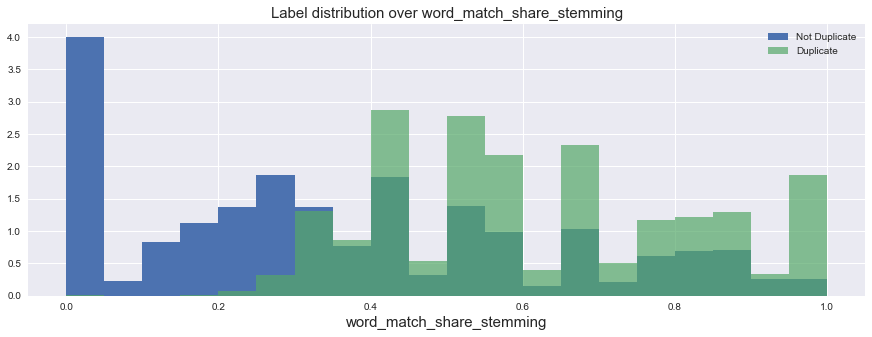

In [93]:
################ EDA for share word weight with stem ##################
# trainWeightPd0["weight"]
plt.figure(figsize=(15, 5))
plt.hist(trainWeightPd0["weight"], bins=20, normed=True, label='Not Duplicate')
plt.hist(trainWeightPd1["weight"], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share_stemming', fontsize=15)
plt.xlabel('word_match_share_stemming', fontsize=15)
plt.show()

In [57]:
######## serialize out testDataWithWords with stem for scala with xgboost#########
testOut=testDataWithWords.select(["test_id", doStem2(col("words1")).alias("words1") \
                                           ,doStem2(col("words2")).alias("words2")])
testOut=testOut.select("*", getWeight2(col("words1"),col("words2")).alias("weight"))
testOut.take(1)

[Row(test_id=u'0', words1=u'surfac-pro-4-compar-ipad-pro', words2=u'microsoft-choos-core-m3-core-i3-home-surfac-pro-4', weight=u'0.4375')]

In [58]:
######## serialize out testDataWithWords with stem for scala with xgboost#########
testDataStemPd=testOut.toPandas()
testDataStemPd.to_csv(Path.replace("file:","") + "/QuoraQuestion/testDataStem.csv",index=False, encoding="utf-8")

In [52]:
import re, string
s="step step guid invest share market india?"
regex = re.compile('[%s]' % re.escape(string.punctuation))
regex.sub('', s)
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [22]:
############# Prepare to Predict Test Data of Shared Word weight with stem ##########
testData2=testDataWithWords.select(["test_id",  \
                                                     split(doStem(col("words1")), ",").alias("words1"), \
                                                     split(doStem(col("words2")),",").alias("words2")])
testData2.show(5)
testData2.printSchema()

+-------+--------------------+--------------------+
|test_id|              words1|              words2|
+-------+--------------------+--------------------+
|      0|[surfac, pro, 4, ...|[microsoft, choos...|
|      1|[hair, transplant...|[much, cost, hair...|
|      2|[best, way, send,...|[send, money, chi...|
|      3|[food, emulsifiers?]|     [food, fibre?"]|
|      4|[""aberystwyth"",...|  [start, reading?"]|
+-------+--------------------+--------------------+
only showing top 5 rows

root
 |-- test_id: string (nullable = true)
 |-- words1: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- words2: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [101]:
############# get weight to Predict Test Data of Shared Word weight with stem ##########
testWeightData2=testData2.select(["test_id","words1", "words2",getWeight(col("words1"),col("words2")).alias("weight")])

In [102]:
############# Output for Predict Test Data of Shared Word weight with stem ##########
# submitPd2=testWeightData2.select(col("test_id"), col("weight").alias("is_duplicate")).toPandas()
# submitPd2.to_csv(Path.replace("file:","") + "/QuoraQuestion/submit2.csv",index=False)

In [23]:
from pyspark.sql.functions import when, log, col
epsilon = 1e-16

def compute_log_loss(trainData):
    """Computes and adds a 'log_loss' column to a DataFrame using 'p' and 'label' columns.

    Note:
        log(0) is undefined, so when p is 0 we add a small value (epsilon) to it and when
        p is 1 we subtract a small value (epsilon) from it.

    Args:
        df (DataFrame with 'p' and 'label' columns): A DataFrame with a probability column
            'p' and a 'label' column that corresponds to y in the log loss formula.

    Returns:
        DataFrame: A new DataFrame with an additional column called 'log_loss' where 'log_loss' column contains the loss value as explained above.
    """
    newDF = trainData.select("*", when(trainData.is_duplicate == 1, 0. - log(trainData.weight + epsilon)).\
                           otherwise(0. - log(1. - trainData.weight + epsilon)).alias('log_loss'))
  
    retObj = newDF  
      
    return retObj

In [24]:
#TF-IDF features
from pyspark.ml.feature import HashingTF, IDF
# trainDataWithWords.printSchema()
# wordsDf1=trainDataWithWords.select("id", "qid1", col("words1").alias("words"), "is_duplicate")
# wordsDf2=trainDataWithWords.select("id", "qid2", col("words2").alias("words"))
wordsDf1=trainData2.select("id", "qid1", col("words1").alias("words"), getWeight(col("words1"), col("words2")).alias("weight"),"is_duplicate")
wordsDf2=trainData2.select("id", "qid2", col("words2").alias("words"))
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=64)
featurizedData = hashingTF.transform(wordsDf1.select("id","words").union(wordsDf2.select("id","words")))
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
wordsDf1 = idfModel.transform(hashingTF.transform(wordsDf1))
wordsDf2 = idfModel.transform(hashingTF.transform(wordsDf2))

In [25]:
trainData2.printSchema()

root
 |-- id: string (nullable = true)
 |-- qid1: double (nullable = true)
 |-- words1: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- qid2: double (nullable = true)
 |-- words2: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- is_duplicate: double (nullable = true)



In [26]:
trainTfidfData=wordsDf1.select("id", "qid1", col("features").alias("features1"), col("weight").cast("double"), "is_duplicate") \
        .join(wordsDf2.select("id", "qid2", col("features").alias("features2")), wordsDf1.id==wordsDf2.id)
trainTfidfData.printSchema()
trainTfidfData.show(1)

root
 |-- id: string (nullable = true)
 |-- qid1: double (nullable = true)
 |-- features1: vector (nullable = true)
 |-- weight: double (nullable = true)
 |-- is_duplicate: double (nullable = true)
 |-- id: string (nullable = true)
 |-- qid2: double (nullable = true)
 |-- features2: vector (nullable = true)

+------+--------+--------------------+------+------------+------+--------+--------------------+
|    id|    qid1|           features1|weight|is_duplicate|    id|    qid2|           features2|
+------+--------+--------------------+------+------------+------+--------+--------------------+
|100010|165949.0|(64,[24,27],[2.27...|   0.8|         0.0|100010|165950.0|(64,[24,27],[2.27...|
+------+--------+--------------------+------+------------+------+--------+--------------------+
only showing top 1 row



In [27]:
#vector assembler
from pyspark.ml.feature import VectorAssembler
assemblerInputs=["weight","features1", "features2"]
print assemblerInputs
assembler=VectorAssembler(inputCols=assemblerInputs, outputCol="features")
#random forest
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
rf=RandomForestClassifier(labelCol="is_duplicate", featuresCol="features" \
                          , numTrees=5, impurity="entropy", maxDepth=20, maxBins=10)
#lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0.8, labelCol="is_duplicate", featuresCol="features")
#random split
trainTfidfData0=trainTfidfData.filter("is_duplicate=0")
trainTfidfData1=trainTfidfData.filter("is_duplicate=1")
splitPop = [0.9,0.1]
(trainDataS0, trainDataV0)=trainTfidfData0.randomSplit(splitPop)
(trainDataS1, trainDataV1)=trainTfidfData1.randomSplit(splitPop)
trainDataS = trainDataS0.union(trainDataS1)
trainDataV = trainDataV0.union(trainDataV1)
#using pipleline
from pyspark.ml import Pipeline
pipelineTfidf=Pipeline(stages=[assembler, rf])
tfIdfModel=pipelineTfidf.fit(trainDataS)

['weight', 'features1', 'features2']


In [28]:
prdictionTrainV=tfIdfModel.transform(trainDataV)
prdictionTrainV.printSchema()
def getFirstElement(vec):
    return float(vec[1])
getFirstElement=udf(getFirstElement)
computeDf = prdictionTrainV.select([getFirstElement(col("probability")).alias("weight"), "is_duplicate"])

root
 |-- id: string (nullable = true)
 |-- qid1: double (nullable = true)
 |-- features1: vector (nullable = true)
 |-- weight: double (nullable = true)
 |-- is_duplicate: double (nullable = true)
 |-- id: string (nullable = true)
 |-- qid2: double (nullable = true)
 |-- features2: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [29]:
#computeDf.take(1)
compute_log_loss(computeDf).describe('log_loss').show()
#logloss of no stemming with feature 32+32
"""
+-------+------------------+
|summary|          log_loss|
+-------+------------------+
|  count|             81133|
|   mean|0.6168502140578057|
| stddev|0.2902043101008879|
|    min|               0.0|
|    max| 4.223177434065062|
+-------+------------------+
"""

+-------+-------------------+
|summary|           log_loss|
+-------+-------------------+
|  count|              40206|
|   mean|0.49290633868590306|
| stddev| 0.5048350773071514|
|    min|                0.0|
|    max| 36.841361487904734|
+-------+-------------------+



'\n+-------+------------------+\n|summary|          log_loss|\n+-------+------------------+\n|  count|             81133|\n|   mean|0.6168502140578057|\n| stddev|0.2902043101008879|\n|    min|               0.0|\n|    max| 4.223177434065062|\n+-------+------------------+\n'

In [30]:
#prdictionTrainV.take(1)

In [31]:
#evaluate with evaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [32]:
evaluator=BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="is_duplicate", metricName="areaUnderROC")
auc=evaluator.evaluate(prdictionTrainV)
auc

0.8184033440193541

In [33]:
############# Predict Testing Data by TF-IDF #############
testWordsDf1=testData2.select("test_id", col("words1").alias("words"), getWeight(col("words1"), col("words2")).alias("weight"))
testWordsDf2=testData2.select("test_id", col("words2").alias("words"))
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=64)
featurizedData = hashingTF.transform(testWordsDf1.select("test_id","words").union(testWordsDf2.select("test_id","words")))
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
testWordsDf1 = idfModel.transform(hashingTF.transform(testWordsDf1))
testWordsDf2 = idfModel.transform(hashingTF.transform(testWordsDf2))


In [34]:
############# Predict Testing Data by TF-IDF #############
testTfidfData=testWordsDf1.select("test_id", col("features").alias("features1"), col("weight").cast("double")) \
        .join(testWordsDf2.select("test_id", col("features").alias("features2")), testWordsDf1.test_id==testWordsDf2.test_id) \
        .drop(testWordsDf2.test_id)
#testTfidfData.printSchema()
testTfidfData2=assembler.transform(testTfidfData)
testTfidfData2.printSchema()

root
 |-- features1: vector (nullable = true)
 |-- weight: double (nullable = true)
 |-- test_id: string (nullable = true)
 |-- features2: vector (nullable = true)
 |-- features: vector (nullable = true)



In [35]:
tfIdfModel.stages[1]

RandomForestClassificationModel (uid=rfc_041bea905fad) with 5 trees

In [36]:
############# Predict Testing Data by TF-IDF #############
prdictionTest=tfIdfModel.stages[1].transform(testTfidfData2)
prdictionTest.printSchema()

root
 |-- features1: vector (nullable = true)
 |-- weight: double (nullable = true)
 |-- test_id: string (nullable = true)
 |-- features2: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [37]:
############# Generate Predict Result by using TF-IDF #############
predictionDf = prdictionTest.select([col("test_id").cast("integer"), getFirstElement(col("probability")).alias("is_duplicate")]).orderBy("test_id", ascending=[1])
predictionDf.printSchema()
#submitPd3=predictionDf.toPandas()
#submitPd3.to_csv(Path.replace("file:","") + "/QuoraQuestion/submit3.csv",index=False)

root
 |-- test_id: integer (nullable = true)
 |-- is_duplicate: string (nullable = true)



In [38]:
wordsDf1=wordsDf1.drop("featuresW2V")
wordsDf2=wordsDf2.drop("featuresW2V")
wordsDf1.printSchema()

root
 |-- id: string (nullable = true)
 |-- qid1: double (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- weight: string (nullable = true)
 |-- is_duplicate: double (nullable = true)
 |-- rawFeatures: vector (nullable = true)
 |-- features: vector (nullable = true)



In [39]:
#Using Word2Vec
from pyspark.ml.feature import Word2Vec
word2Vec = Word2Vec(vectorSize=15, minCount=2, inputCol="words", outputCol="featuresW2V")
wordsDf=wordsDf1.select("id","words").union(wordsDf2.select("id","words"))
w2vModel=word2Vec.fit(wordsDf)

wordsDf1 = w2vModel.transform(wordsDf1)
wordsDf2 = w2vModel.transform(wordsDf2)

trainW2VData=wordsDf1.select("id", "qid1", col("features").alias("features1"), col("featuresW2V").alias("featuresW2V1"), col("weight").cast("double"), "is_duplicate") \
        .join(wordsDf2.select("id", "qid2", col("features").alias("features2"), col("featuresW2V").alias("featuresW2V2")), wordsDf1.id==wordsDf2.id).drop(wordsDf2.id)
trainW2VData.printSchema()
# trainW2VData.show(1)

root
 |-- qid1: double (nullable = true)
 |-- features1: vector (nullable = true)
 |-- featuresW2V1: vector (nullable = true)
 |-- weight: double (nullable = true)
 |-- is_duplicate: double (nullable = true)
 |-- id: string (nullable = true)
 |-- qid2: double (nullable = true)
 |-- features2: vector (nullable = true)
 |-- featuresW2V2: vector (nullable = true)



In [40]:
#trainW2VData.show(1)

In [41]:
## Word2Vec for training Data
from pyspark.ml.feature import VectorAssembler
assemblerInputs=["weight","features1","features2", "featuresW2V1", "featuresW2V2"]
print assemblerInputs
assembler=VectorAssembler(inputCols=assemblerInputs, outputCol="features")
#random forest
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
rf=RandomForestClassifier(labelCol="is_duplicate", featuresCol="features" \
                          , numTrees=5, impurity="entropy", maxDepth=20, maxBins=10)
#lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0.8, labelCol="is_duplicate", featuresCol="features")
#random split
trainW2VData0=trainW2VData.filter("is_duplicate=0")
trainW2VData1=trainW2VData.filter("is_duplicate=1")
splitPop = [0.9,0.1]
(trainDataS0, trainDataV0)=trainW2VData0.randomSplit(splitPop)
(trainDataS1, trainDataV1)=trainW2VData1.randomSplit(splitPop)
trainDataS = trainDataS0.union(trainDataS1)
trainDataV = trainDataV0.union(trainDataV1)
#using pipleline
from pyspark.ml import Pipeline
pipelineW2V=Pipeline(stages=[assembler, rf])
w2vModel=pipelineW2V.fit(trainDataS)

['weight', 'features1', 'features2', 'featuresW2V1', 'featuresW2V2']


In [42]:
## Word2Vec for predict training Data
prdictionTrainV=w2vModel.transform(trainDataV)
prdictionTrainV.printSchema()
def getFirstElement(vec):
    return float(vec[1])
getFirstElement=udf(getFirstElement)
computeDf = prdictionTrainV.select([getFirstElement(col("probability")).alias("weight"), "is_duplicate"])

root
 |-- qid1: double (nullable = true)
 |-- features1: vector (nullable = true)
 |-- featuresW2V1: vector (nullable = true)
 |-- weight: double (nullable = true)
 |-- is_duplicate: double (nullable = true)
 |-- id: string (nullable = true)
 |-- qid2: double (nullable = true)
 |-- features2: vector (nullable = true)
 |-- featuresW2V2: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [43]:
## Word2Vec for training Data (logLoss)
compute_log_loss(computeDf).describe('log_loss').show()

+-------+-------------------+
|summary|           log_loss|
+-------+-------------------+
|  count|              40135|
|   mean|0.44768735141243815|
| stddev| 0.9932865959026336|
|    min|                0.0|
|    max| 36.841361487904734|
+-------+-------------------+



In [44]:
evaluator=BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="is_duplicate", metricName="areaUnderROC")
auc=evaluator.evaluate(prdictionTrainV)
auc

0.8657146828582122

In [45]:
######### prepare testing data for predict using TF-IDF + WordVec ###########
testWordsDf1=testWordsDf1.drop("featuresW2V")
testWordsDf2=testWordsDf2.drop("featuresW2V")
testWordsDf1.printSchema()

root
 |-- test_id: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- weight: string (nullable = true)
 |-- rawFeatures: vector (nullable = true)
 |-- features: vector (nullable = true)



In [46]:
######### prepare testing data for predict using TF-IDF + WordVec ###########
testWordsDf=testWordsDf1.select("test_id","words").union(testWordsDf2.select("test_id","words"))
w2v=word2Vec.fit(testWordsDf)

testWordsDf1 = w2v.transform(testWordsDf1)
testWordsDf2 = w2v.transform(testWordsDf2)

testW2VData=testWordsDf1.select("test_id", col("features").alias("features1"), col("featuresW2V").alias("featuresW2V1"), col("weight").cast("double")) \
        .join(testWordsDf2.select("test_id", col("features").alias("features2"), col("featuresW2V").alias("featuresW2V2")) \
              , testWordsDf1.test_id==testWordsDf2.test_id).drop(testWordsDf2.test_id)
testW2VData.printSchema()

root
 |-- features1: vector (nullable = true)
 |-- featuresW2V1: vector (nullable = true)
 |-- weight: double (nullable = true)
 |-- test_id: string (nullable = true)
 |-- features2: vector (nullable = true)
 |-- featuresW2V2: vector (nullable = true)



In [47]:
######### prepare testing data for predict using TF-IDF + WordVec ###########
testW2VData2=assembler.transform(testW2VData)
testW2VData2.printSchema()

root
 |-- features1: vector (nullable = true)
 |-- featuresW2V1: vector (nullable = true)
 |-- weight: double (nullable = true)
 |-- test_id: string (nullable = true)
 |-- features2: vector (nullable = true)
 |-- featuresW2V2: vector (nullable = true)
 |-- features: vector (nullable = true)



In [48]:
w2vModel.stages[0]

VectorAssembler_48ba8099fb1d347afeaf

In [49]:
############# Predict Testing Data by Word2Vec #############
prdictionTest=w2vModel.stages[1].transform(testW2VData2)
prdictionTest.printSchema()

root
 |-- features1: vector (nullable = true)
 |-- featuresW2V1: vector (nullable = true)
 |-- weight: double (nullable = true)
 |-- test_id: string (nullable = true)
 |-- features2: vector (nullable = true)
 |-- featuresW2V2: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [50]:
############# Generate Predict Result by using Word2Vec #############
predictionDf = prdictionTest.select([col("test_id").cast("integer"), getFirstElement(col("probability")).alias("is_duplicate")]).orderBy("test_id", ascending=[1])
predictionDf.printSchema()
submitPd4=predictionDf.toPandas()
submitPd4.to_csv(Path.replace("file:","") + "/QuoraQuestion/submit4.csv",index=False)

root
 |-- test_id: integer (nullable = true)
 |-- is_duplicate: string (nullable = true)

